<a href="https://colab.research.google.com/github/jhlopesalves/classic_workflows/blob/main/LLM/book_recommender/text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import getpass
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from enum import Enum
from pathlib import Path
from typing import List, Tuple

import instructor
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import seaborn.objects as so
from google.colab import userdata
from openai import OpenAI
from pydantic import BaseModel, Field
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm

In [9]:
# Secure API Key Handling
try:
    OR_API_KEY = userdata.get("OPEN_ROUTER")
except Exception:
    OR_API_KEY = getpass.getpass("Enter OpenRouter API Key: ")

# Initialize the Instructor Client
client = instructor.from_openai(
    OpenAI(
        base_url="https://openrouter.ai/api/v1",
        api_key=OR_API_KEY,
    ),
    mode=instructor.Mode.JSON,
)

In [12]:
# Path to cleaned dataset (colab-friendly)
books_path = Path("/content/data/books_cleaned.csv")

# load the cleaned dataset
books = pd.read_csv(books_path)
books.head()

,isbn13,isbn10,title,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,title_and_subtitle,tagged_description
0,9780002005883,0002005883,Gilead,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,Gilead,9780002005883 A NOVEL THAT READERS and critics...
1,9780002261982,0002261987,Spider's Web,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,Spider's Web: A Novel,9780002261982 A new 'Christie for Christmas' -...
2,9780006178736,0006178731,Rage of angels,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,Rage of angels,"9780006178736 A memorable, mesmerizing heroine..."
3,9780006280897,0006280897,The Four Loves,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,The Four Loves,9780006280897 Lewis' work on the nature of lov...
4,9780006280934,0006280935,The Problem of Pain,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,The Problem of Pain,"9780006280934 ""In The Problem of Pain, C.S. Le..."


In [13]:
category_mapping = {
	"Fiction": "Fiction",
	"Juvenile Fiction": "Children's Fiction",
	"Biography & Autobiography": "Nonfiction",
	"History": "Nonfiction",
	"Literary Criticism": "Nonfiction",
	"Philosophy": "Nonfiction",
	"Religion": "Nonfiction",
	"Comics & Graphic Novels": "Fiction",
	"Drama": "Fiction",
	"Juvenile Nonfiction": "Children's Nonfiction",
	"Science": "Nonfiction",
	"Poetry": "Fiction",
}

books["simple_categories"] = books["categories"].map(category_mapping)

In [14]:
books.head()

,isbn13,isbn10,title,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,title_and_subtitle,tagged_description,simple_categories
0,9780002005883,0002005883,Gilead,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,Gilead,9780002005883 A NOVEL THAT READERS and critics...,Fiction
1,9780002261982,0002261987,Spider's Web,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,Spider's Web: A Novel,9780002261982 A new 'Christie for Christmas' -...,NaN
2,9780006178736,0006178731,Rage of angels,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,Rage of angels,"9780006178736 A memorable, mesmerizing heroine...",Fiction
3,9780006280897,0006280897,The Four Loves,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,The Four Loves,9780006280897 Lewis' work on the nature of lov...,NaN
4,9780006280934,0006280935,The Problem of Pain,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,The Problem of Pain,"9780006280934 ""In The Problem of Pain, C.S. Le...",NaN


In [19]:
class BookCategory(str, Enum):
    """Strict enumeration to prevent model hallucination."""
    FICTION = "Fiction"
    NONFICTION = "Nonfiction"

class BookClassification(BaseModel):
    category: BookCategory

def classify_description(text: str, model: str = "deepseek/deepseek-v3.2-speciale") -> str:
    """
    Sends one book description to the LLM.
    Returns: 'Fiction', 'Nonfiction', or 'Error'.
    """
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {
                    "role": "system",
                    "content": "Classify this book description as strictly 'Fiction' or 'Nonfiction'."
                },
                {"role": "user", "content": text},
            ],
            response_model=BookClassification,
            temperature=0.0,
            max_retries=2,
        )
        return response.category.value
    except Exception:
        return "Error"

def run_batch_classification(sequences: List[str], label: str, max_workers: int = 15):
    """
    Parallel processing with ThreadPoolExecutor.
    """
    preds = []
    actuals = []

    # ThreadPoolExecutor allows us to send multiple requests at once
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_seq = {executor.submit(classify_description, seq): seq for seq in sequences}

        for future in tqdm(as_completed(future_to_seq), total=len(sequences), desc=f"Classifying {label}"):
            try:
                result = future.result()
                preds.append(result)
                actuals.append(label)
            except Exception:
                preds.append("Error")
                actuals.append(label)

    return preds, actuals

In [17]:
# Configuration
SUBSET_SIZE = 300
MAX_WORKERS = 15    # Safe default for DeepSeek/OpenRouter to avoid rate limits

# Sample specifically to ensure we have ground truth for both classes
subset_fiction = books[books["simple_categories"] == "Fiction"].sample(n=SUBSET_SIZE, random_state=42)
subset_nonfiction = books[books["simple_categories"] == "Nonfiction"].sample(n=SUBSET_SIZE, random_state=42)

sequences_fic = subset_fiction["description"].tolist()
sequences_non = subset_nonfiction["description"].tolist()

# Run Classification
print(f"Starting classification of {len(sequences_fic) + len(sequences_non)} items...")

preds_fic, actuals_fic = run_batch_classification(sequences_fic, "Fiction", max_workers=MAX_WORKERS)
preds_non, actuals_non = run_batch_classification(sequences_non, "Nonfiction", max_workers=MAX_WORKERS)

# Aggregation & Cleaning
all_preds = preds_fic + preds_non
all_actuals = actuals_fic + actuals_non

# Filter out API errors
clean_data = [(t, p) for t, p in zip(all_actuals, all_preds) if p != "Error"]
y_true = [x[0] for x in clean_data]
y_pred = [x[1] for x in clean_data]

error_count = len(all_preds) - len(y_pred)
if error_count > 0:
    print(f"\nNote: {error_count} requests failed and were excluded from metrics.")

# Metrics
acc = accuracy_score(y_true, y_pred)
print(f"\nFinal LLM Accuracy: {acc:.2%}")
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred))

Starting classification of 600 items...


Classifying Nonfiction: 100%|██████████| 300/300 [18:58<00:00,  3.79s/it]


Final LLM Accuracy: 95.83%

Classification Report:

              precision    recall  f1-score   support

     Fiction       0.97      0.94      0.96       300
  Nonfiction       0.94      0.97      0.96       300

    accuracy                           0.96       600
   macro avg       0.96      0.96      0.96       600
weighted avg       0.96      0.96      0.96       600



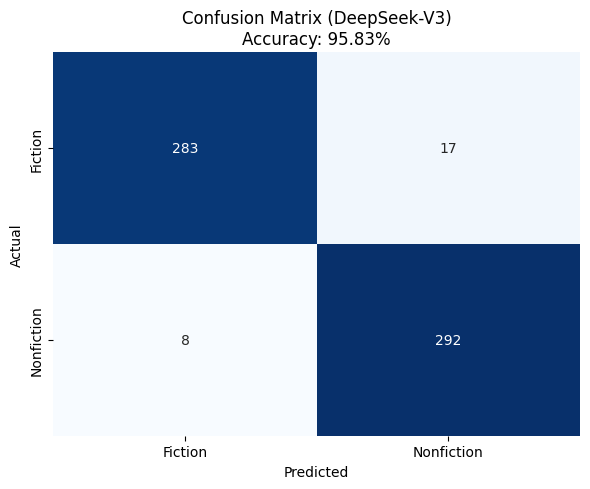

In [18]:
cm = confusion_matrix(y_true, y_pred, labels=["Fiction", "Nonfiction"])

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=["Fiction", "Nonfiction"],
    yticklabels=["Fiction", "Nonfiction"]
)
plt.title(f"Confusion Matrix (DeepSeek-V3)\nAccuracy: {acc:.2%}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [21]:
missing_mask = books["simple_categories"].isna()
missing_books = books[missing_mask].copy()

if len(missing_books) > 0:
    # Run Batch Classification
    sequences = missing_books["description"].tolist()

    print(f"Starting batch prediction for {len(sequences)} items...")

    new_preds, _ = run_batch_classification(
        sequences,
        label="Unknown",
        max_workers=20 # Safe speed for OpenRouter
    )

    # 3. Assign Results Back to DataFrame
    # Map the predictions directly to the matching indices in the original dataframe
    books.loc[missing_mask, "simple_categories"] = new_preds

    # 4. Handle Errors (Optional)
    # If any API calls failed (returned "Error"). For now, leave "Error" strings so you see them.
    error_count = (books.loc[missing_mask, "simple_categories"] == "Error").sum()
    if error_count > 0:
        print(f"Warning: {error_count} predictions failed (marked as 'Error').")

else:
    print("No missing categories found!")

Starting batch prediction for 1454 items...


Classifying Unknown: 100%|██████████| 1454/1454 [41:38<00:00,  1.72s/it]


In [22]:
output_filename = "books_with_categories.csv"
books.to_csv(output_filename, index=False)

print(books.loc[missing_mask, ["title", "simple_categories"]].head())

                    title simple_categories
1            Spider's Web           Fiction
3          The Four Loves        Nonfiction
4     The Problem of Pain           Fiction
5  Empires of the Monsoon           Fiction
6    The Gap Into Madness           Fiction
